In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import plotly.express as px

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.set_index('date',inplace=True)

In [4]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


<h2 style="color:red;text-align:center;">Sales Total Storewise</h2>

In [5]:
store_sales=df.groupby(by='store')[['sales']].sum()
store_sales

,sales
store,
1,4315603
2,6120128
3,5435144
4,5012639
5,3631016
6,3627670
7,3320009
8,5856169
9,5025976


In [6]:
store=store_sales.index

In [7]:
fig = px.bar(store_sales,color=store)
fig.show()

In [8]:
fig = px.histogram(df[df.item==1][['sales']],labels=dict(value="Sales"))
fig.show()


In [9]:
fig = px.line(df[(df.item==1) & (df.store==4)][['sales']],y='sales')
fig.show()

## Predict 3 months of sales for 50 different items at 10 different stores.

In [10]:
df_1_1=df[(df.item==1) & (df.store==1)][['sales']]

In [11]:
fig = px.line(df_1_1)
fig.show()


## Stationary
mean,variance and co-variance is constant over periods

<Figure size 3600x2400 with 0 Axes>

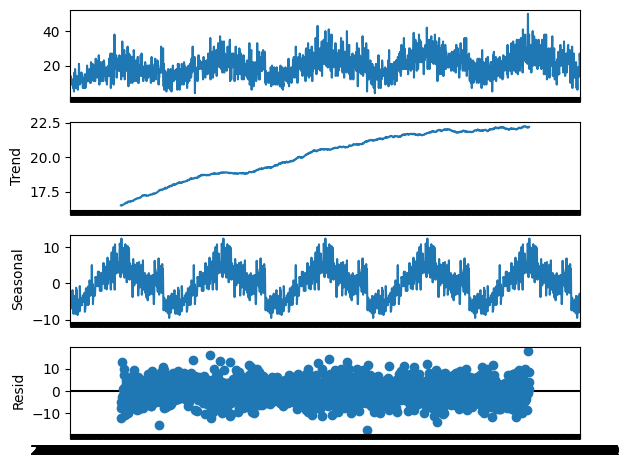

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_1_1, model='additive', period=365)
plt.figure(figsize=(36, 24))
result.plot()
plt.show()

<Axes: xlabel='date'>

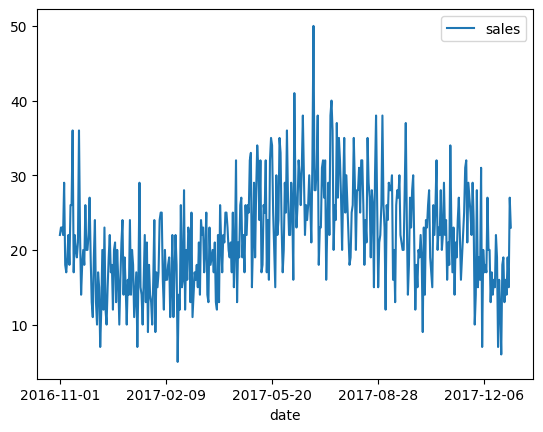

In [13]:
df_1_1.iloc[1400:,].plot()

In [14]:
pd.options.plotting.backend = "plotly"

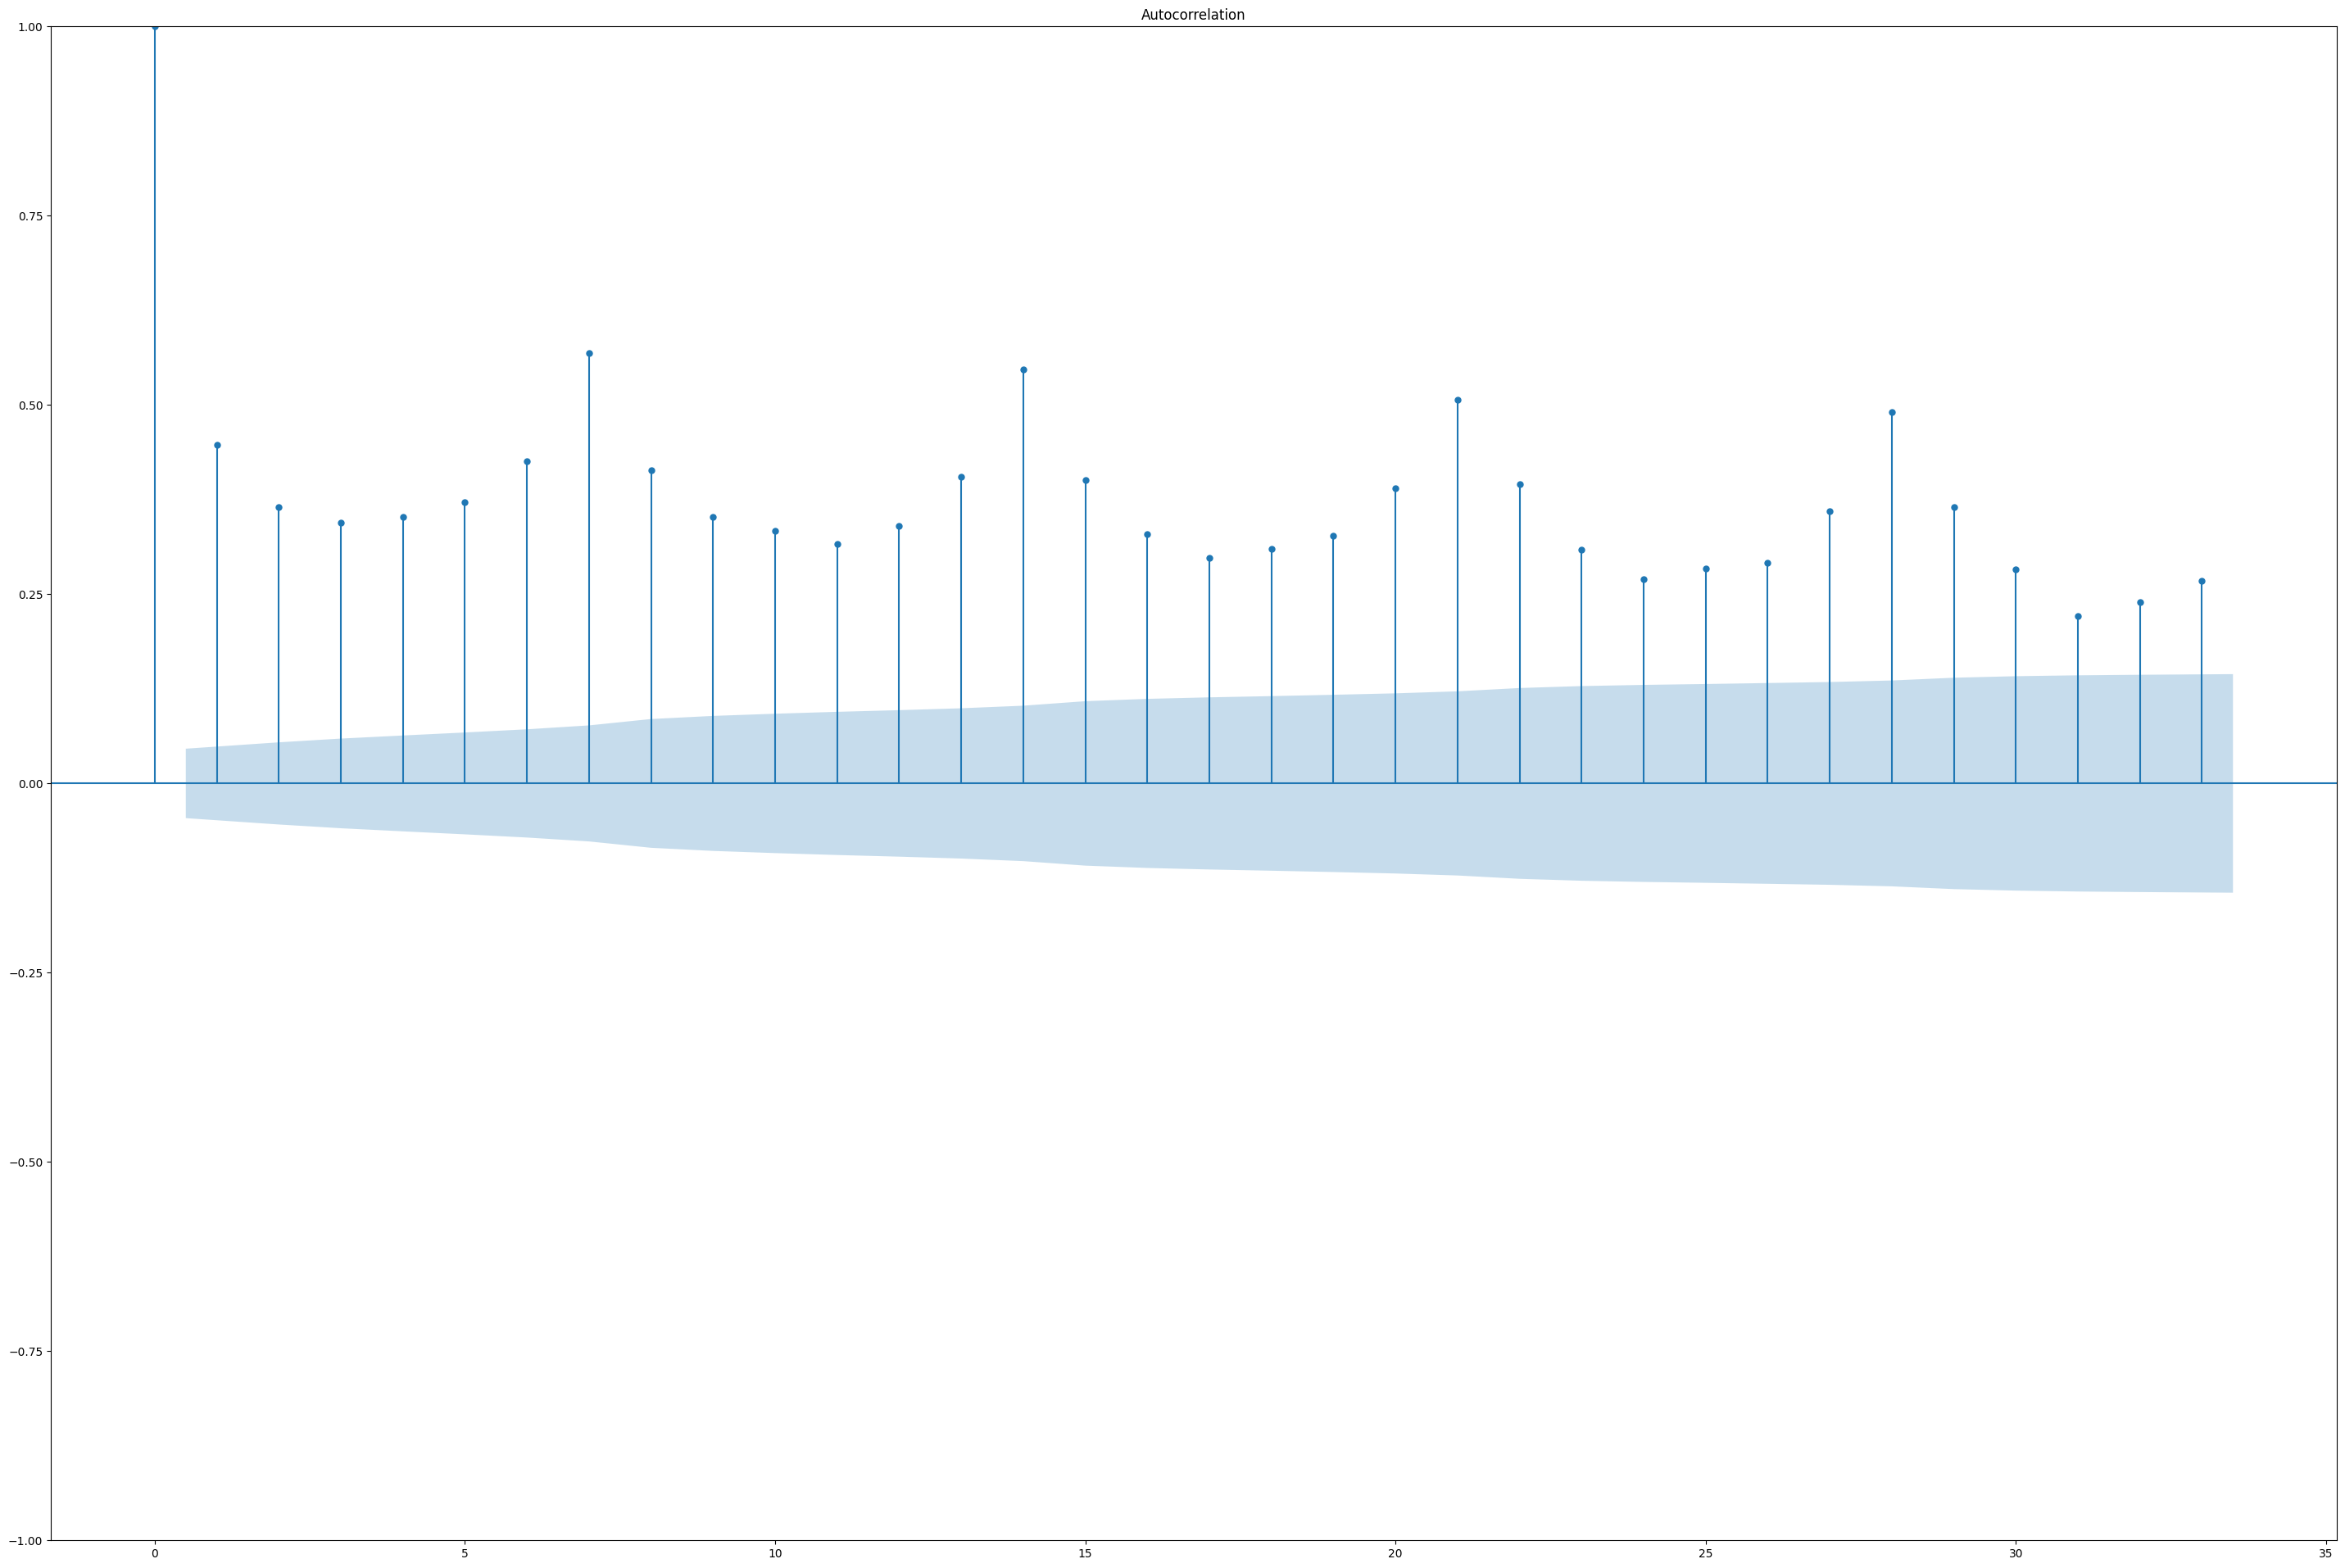

In [15]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(36,24))
sm.graphics.tsa.plot_acf(df_1_1, ax=ax)
plt.show()

### Check for stationary using Ad Fuller Hypothesis test

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

<strong>Null Hypothesis (H0):</strong> If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

<strong>p-value > 0.05:</strong> Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

<strong>p-value <= 0.05:</strong> Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [16]:
from statsmodels.tsa.stattools import adfuller
hypothesis_test=adfuller(df_1_1)
print('ADF Statistic: %f' % hypothesis_test[0])
print('p-value: %f' % hypothesis_test[1])
print('Critical Values:')
for key, value in hypothesis_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### The more negative this statistic, the more likely we are to reject the null hypothesis

<h2><center>Histogram</center></h2>

In [19]:
fig = px.histogram(df_1_1, title="Histogram ", nbins=30)
fig.update_layout(bargap=0.1)
fig.show()


p<0.05 so we reject the null hypothesis and the Time series is Stationary

In [20]:
df_1_1.diff(periods=1).fillna(0).head()

,sales
date,
2013-01-01,0.0
2013-01-02,-2.0
2013-01-03,3.0
2013-01-04,-1.0
2013-01-05,-3.0


In [21]:
df_diff=df_1_1.diff(periods=1) #Integrated of order 1 denoted by d

In [22]:
df_diff=df_diff[1:]
df_diff.head()## 1 Lag

,sales
date,
2013-01-02,-2.0
2013-01-03,3.0
2013-01-04,-1.0
2013-01-05,-3.0
2013-01-06,2.0


In [23]:
fig = px.line(df_diff)
fig.show()


## ARIMA Model

In [24]:
from statsmodels.tsa.arima.model import ARIMA


In [25]:
import itertools
p=d=q=range(0,5)
pdq =list(itertools.product(p,d,q))

In [26]:
X = df_1_1.values
size = int(len(X) * 0.66)
predictions = []

In [27]:
X = df_1_1.values
size = int(len(X) * 0.88)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [28]:
train_date=df_1_1.index[0:size]
test_date=df_1_1.index[size:len(X)]

In [29]:
import warnings
warnings.filterwarnings("ignore")
AIC={}
for i in pdq:
    try:
        model_arima=ARIMA(train,order=(i))
        model_fit=model_arima.fit()
        print(model_fit.aic," ",i)
        AIC[model_fit.aic]=i
    except:
        continue

10589.258825757213   (0, 0, 0)
10367.211558053577   (0, 0, 1)
10292.24873675218   (0, 0, 2)
10235.806148907104   (0, 0, 3)
10225.534338201946   (0, 0, 4)
10791.119185694371   (0, 1, 0)
9910.66119080291   (0, 1, 1)
9906.846994978838   (0, 1, 2)
9903.313527541046   (0, 1, 3)
9887.288179269832   (0, 1, 4)
12476.917019606855   (0, 2, 0)
10794.809898935036   (0, 2, 1)
9921.970190059154   (0, 2, 2)
9916.711356693702   (0, 2, 3)
9914.84604315758   (0, 2, 4)
14367.532990346352   (0, 3, 0)
12479.52569901308   (0, 3, 1)
10834.485081971736   (0, 3, 2)
9953.307053607423   (0, 3, 3)
9952.422429928924   (0, 3, 4)
16347.36217794046   (0, 4, 0)
14369.095440429455   (0, 4, 1)
12488.82745893275   (0, 4, 2)
10839.593995009298   (0, 4, 3)
10084.211637201723   (0, 4, 4)
10262.952804275588   (1, 0, 0)
9916.57788961607   (1, 0, 1)
9912.96129577803   (1, 0, 2)
9909.156382194187   (1, 0, 3)
9892.166745101244   (1, 0, 4)
10454.955245295756   (1, 1, 0)
9907.543771792869   (1, 1, 1)
9903.903615885612   (1, 1, 2)


In [30]:
AIC[min(AIC.keys())]

(2, 1, 3)

In [31]:
model_arima=ARIMA(train,order=(2,1,3))
model_fit=model_arima.fit()


### Selecting the parameter (p,d,q) -> (4,3,2) as it has minimum AIC

In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1606
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -4842.033
Date:                Tue, 01 Apr 2025   AIC                           9696.066
Time:                        13:36:20   BIC                           9728.352
Sample:                             0   HQIC                          9708.053
                               - 1606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2448      0.003    488.308      0.000       1.240       1.250
ar.L2         -0.9957      0.003   -384.461      0.000      -1.001      -0.991
ma.L1         -2.1346      0.014   -147.333      0.000      -2.163      -2.106
ma.L2          2.0797      0.021     97.588      0.000       2.038       2.121
ma.L3         -0.8674      0.014    -60.111      0.000      -0.896      -0.839
sigma2        24.7429      0.835     29.643      0.000      23.107      26.379
===================================================================================
Ljung-Box (L1) (Q):                   5.32   Jarque-Bera (JB):                10.54
Prob(Q):                              0.02   Prob(JB):                         0.01
Heteroskedasticity (H):               1.29   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()
print(residuals.describe())

                 0
count  1606.000000
mean      0.085952
std       4.948276
min     -17.084094
25%      -3.167534
50%      -0.045980
75%       3.227972
max      19.733984


In [34]:
predictions=[]
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts


predicted=27.181679, expected=24.000000
predicted=26.798310, expected=35.000000
predicted=26.201479, expected=33.000000
predicted=24.366484, expected=23.000000
predicted=23.719840, expected=17.000000
predicted=24.177441, expected=20.000000
predicted=26.448457, expected=29.000000
predicted=27.863297, expected=25.000000
predicted=27.808158, expected=36.000000
predicted=26.930328, expected=27.000000
predicted=23.558703, expected=22.000000
predicted=22.873485, expected=22.000000
predicted=24.235981, expected=29.000000
predicted=26.773511, expected=26.000000
predicted=28.245080, expected=16.000000
predicted=27.420651, expected=41.000000
predicted=27.402955, expected=28.000000
predicted=24.383589, expected=23.000000
predicted=23.377519, expected=26.000000
predicted=24.578168, expected=32.000000
predicted=27.306943, expected=30.000000
predicted=29.826400, expected=26.000000
predicted=28.843374, expected=31.000000
predicted=27.767716, expected=38.000000
predicted=26.627221, expected=30.000000


Test RMSE: 5.554


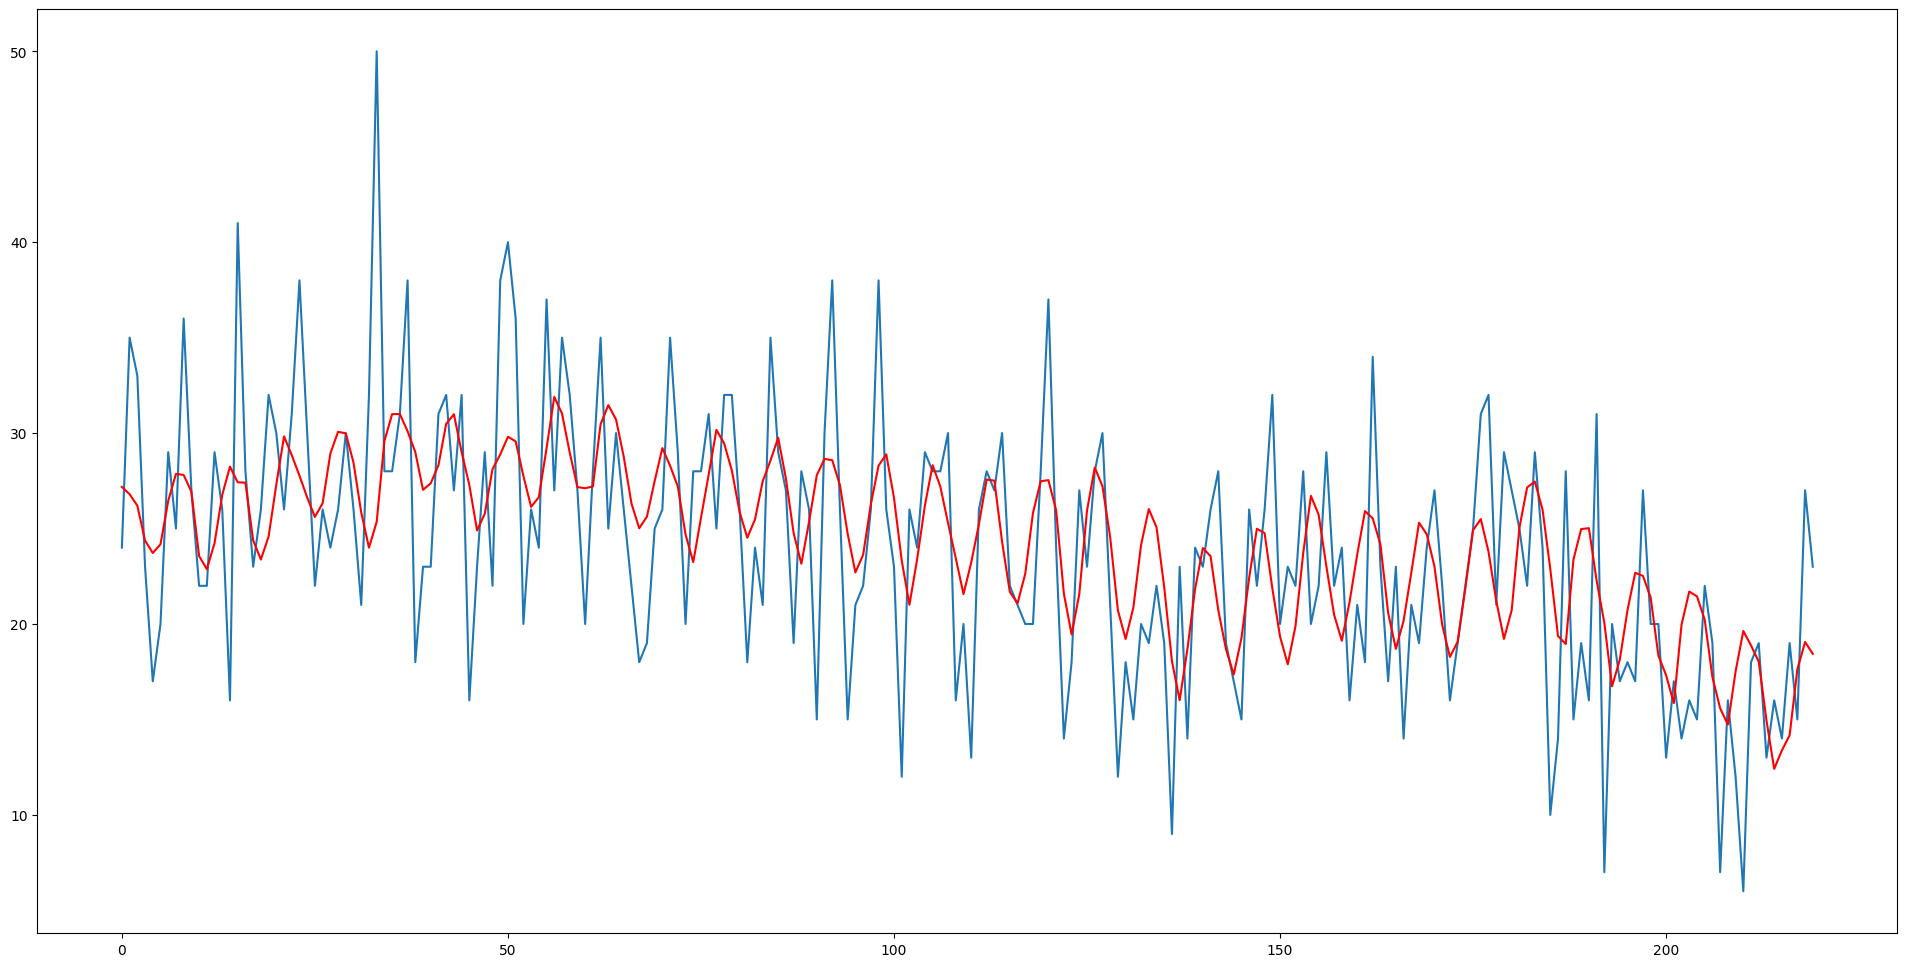

In [37]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(24,12))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:',mean_absolute_error(test.reshape(-1),predictions))

Mean Absolute Error: 4.316665605424137


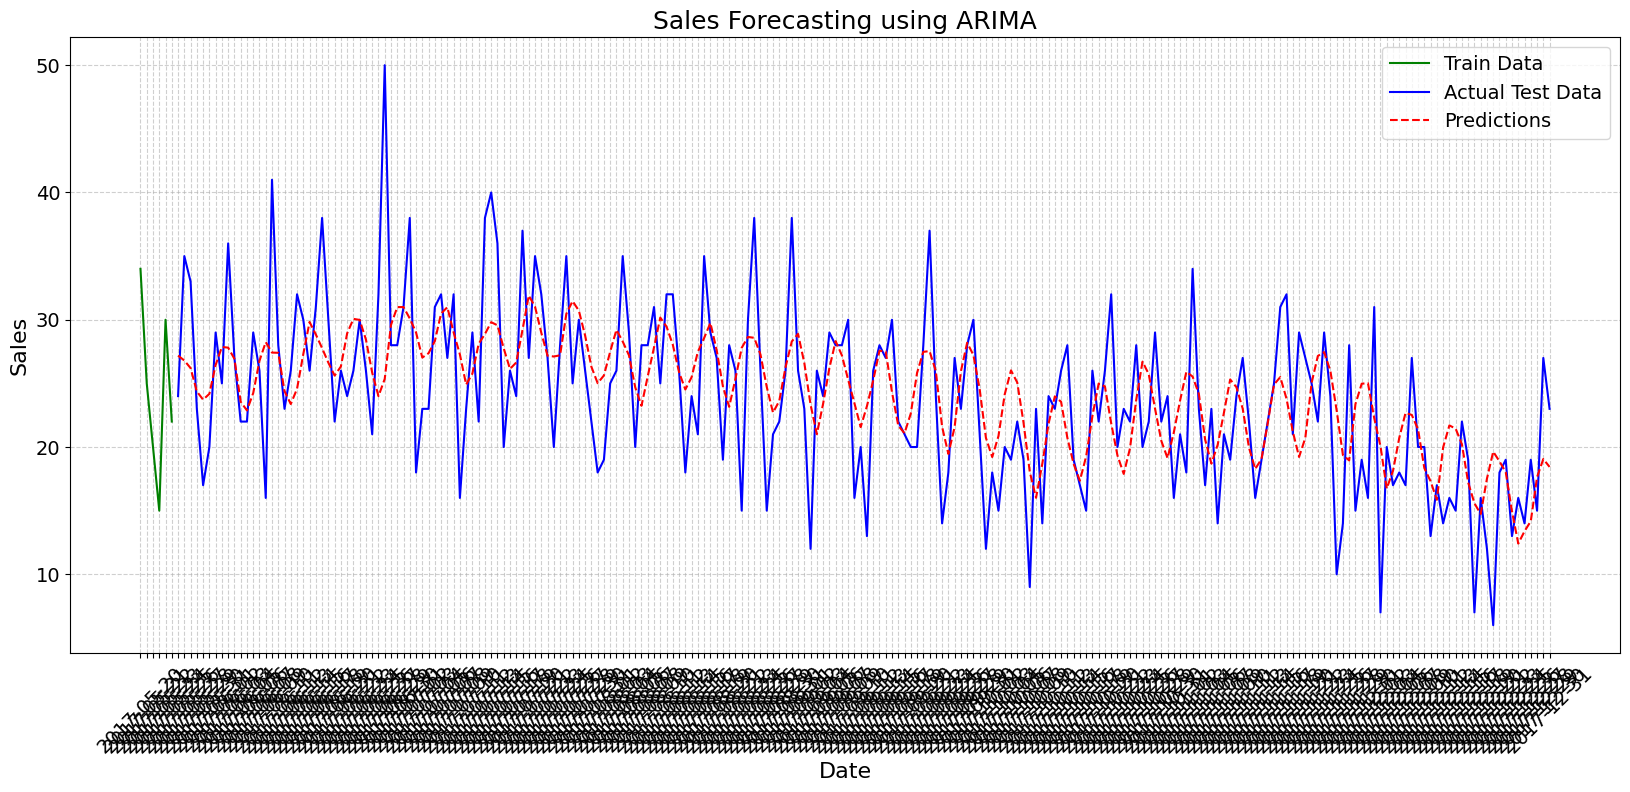

In [40]:
import matplotlib.pyplot as plt

# Set a more reasonable figure size
plt.figure(figsize=(20, 8))

# Plot train, test, and predictions with better styling
plt.plot(train_date[1600:], train[1600:], color='green', label='Train Data')
plt.plot(test_date, test, color='blue', label='Actual Test Data')
plt.plot(test_date, predictions, color='red', linestyle='--', label='Predictions')

# Improve labels and ticks
plt.xticks(rotation=45, fontsize=14)  # Adjust rotation and fontsize for better readability
plt.yticks(fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.title('Sales Forecasting using ARIMA', fontsize=18)

# Add legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Save figure with improved resolution
plt.savefig('Arima.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [41]:
#fig = px.line(train_date,train)
#fig.show()
%matplotlib inline

In [42]:
df_pred=pd.DataFrame({'Predictions':predictions},index=test_date)

In [43]:
#df_1_1.merge(df_pred,'inner',on='index')
